No.of positive_todays= 1038
No.of negative_todays= 960


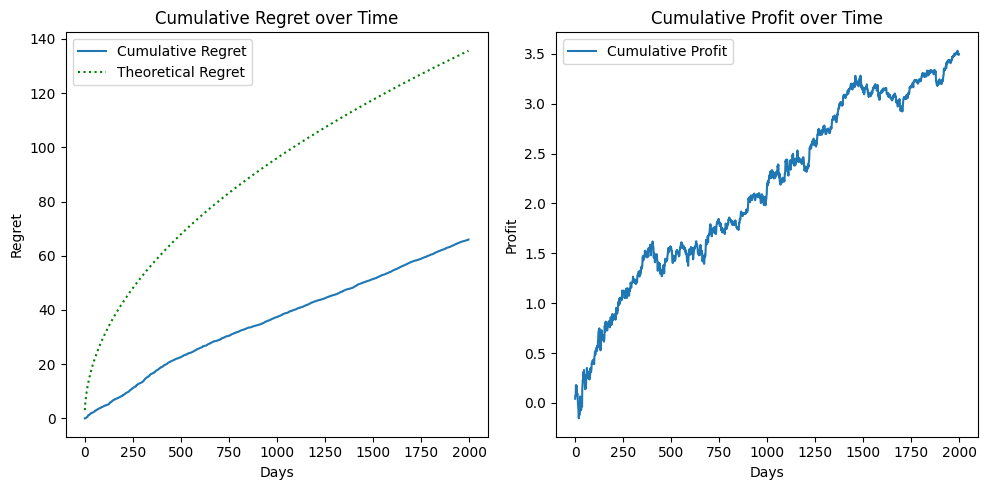

-----------------------------------------------------------
No.of positive_todays= 734
No.of negative_todays= 1264


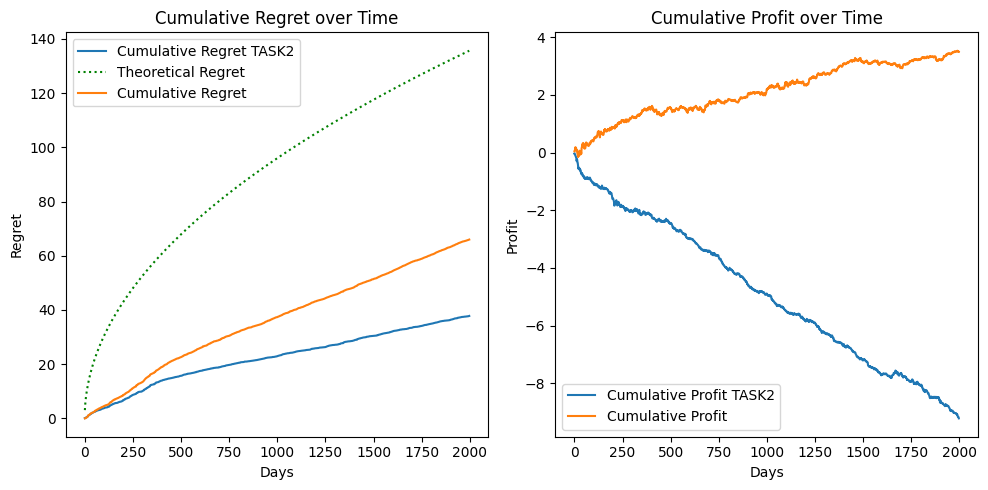

-----------------------------------------------------------


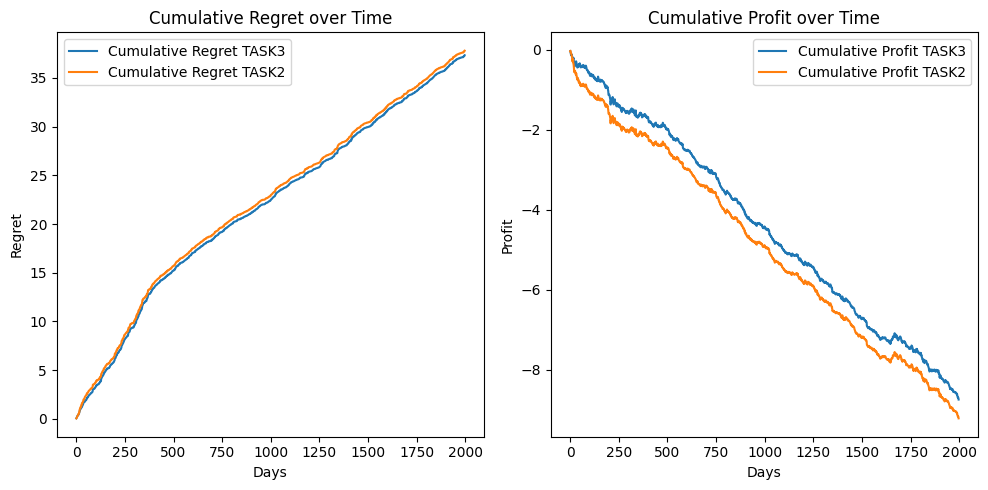

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Function to scale losses in the [-1,1]
def min_max_scaling(X, min_vals, max_vals ):
    min_val=-1
    max_val=1
    # Perform min-max scaling for each feature
    X_scaled = (X - min_vals) / (max_vals - min_vals) * (max_val - min_val) + min_val
    return X_scaled

# Function to read the CSV file and return the data
def read_data(file_path):
    return pd.read_csv(file_path)


# Function to choose an expert based on their weights
def choose_expert(weights):
    #calculates the probabilities of choosing each expert.
    #It normalizes the weights so that they sum up to 1, effectively turning them into probabilities.
    return np.random.choice(len(weights),p=weights/np.sum(weights))

# Function to update the weights of the experts based on their performance (Hedge)
def update_weight(wi_old, li, eta):
    wi_new = wi_old * np.exp(-eta * li)
    return wi_new


def best_worst_expert_considering_fees(data,t,c):
  K = len(data.columns)
  stocks_considering_fees = np.zeros(K)
  stocks_today = data.iloc[t]
  for k in range(K):
    stocks_considering_fees[k] = stocks_today[k] - c[k]
  best_stock =  stocks_considering_fees.max()
  worst_stock = stocks_considering_fees.min()

  return best_stock ,worst_stock


##########################
######  (TASK 1) #########
##########################

def simulate_investment(data):
    positive_todays1=0
    negative_todays1=0

    K = len(data.columns) # number of experts (stocks)
    num_days = len(data)  # horizon

    cumulative_profit = np.zeros(num_days)
    cumulative_regret = np.zeros(num_days)

    weights = np.ones(K) # array to store weights of experts (changes dinamically daily)

    #choose an arbitrary learning rate:
    eta = 0.5

    for t in range(num_days):
        #today im choosing one expert (randomly)
        expert_chosen = choose_expert(weights)

        # ASSUMPTION : I invest 1euro
        # E.g. if for stock 5 you see at day 10 a value +0.023 it means that if you invest 1 euro in this stock,
        # you will get back 0.023 euros for that day.

        # today i will make , or loose this ammount of money :
        today = data.iloc[t, expert_chosen]   # (this is euros)
        if today>0:
          positive_todays1 = positive_todays1 + 1
        else:
          negative_todays1 = negative_todays1 + 1

        # The most amount of money I could make today is :
        max_profit = data.iloc[t].max() # (this is euros)
        min_profit = data.iloc[t].min()
        # Acummulating the money I made
        if t==0:
          cumulative_profit[t] = today
          cumulative_regret[t] = max_profit - today
        else:
          cumulative_profit[t] = cumulative_profit[t-1] + today
          cumulative_regret[t] = cumulative_regret[t-1] + (max_profit - today)

        # Lets see what could happen with each stock for today, despite the fact I didnt choose them
        for i in range(K):
          #today stock no.i would make me earn, or loose:
          today_i = data.iloc[t, i]
          li = min_max_scaling(today_i, min_profit, max_profit)
          weights[i] = update_weight(weights[i], -li, eta)

    print('No.of positive_todays=',positive_todays1)
    print('No.of negative_todays=',negative_todays1)
    return cumulative_profit, cumulative_regret


##########################
######  (TASK 2) #########
##########################

def simulate_investment_2(data):
    positive_todays2=0
    negative_todays2=0

    # transaction fees
    c = np.zeros(10)
    for i in range(10):
      c[i] = c[i-1] + 0.5/100

    K = len(data.columns) # number of experts (stocks)
    num_days = len(data)  # horizon

    cumulative_profit = np.zeros(num_days)
    cumulative_regret = np.zeros(num_days)

    weights = np.ones(K) # array to store weights of experts

    #choose an arbitrary learning rate:
    eta = 0.5

    for t in range(num_days):
        #today im choosing one expert (randomly)
        expert_chosen = choose_expert(weights)

        # ASSUMPTION : I invest 1euro
        # E.g. if for stock 5 you see at day 10 a value +0.023 it means that if you invest 1 euro(!!!) in this stock,
        # you will get back 0.023 euros for that day. So in the fees case if fee=0.05 I will get back (0.023-0.05) euros

        # today i will make , or loose this ammount of money :
        today = data.iloc[t, expert_chosen] - c[expert_chosen]  # (this is euros)
        if today>0:
          positive_todays2 = positive_todays2 + 1
        else:
          negative_todays2 = negative_todays2 + 1


        best_stock ,worst_stock = best_worst_expert_considering_fees(data,t,c)

        # The most amount of money I could make today CONSIDERING THE FEES is :
        max_profit = best_stock # (this is euros)
        min_profit = worst_stock


        # Acummulating the money I made
        if t==0:
          cumulative_profit[t] = today
          cumulative_regret[t] = max_profit - today
        else:
          cumulative_profit[t] = cumulative_profit[t-1] + today
          cumulative_regret[t] = cumulative_regret[t-1] + (max_profit - today)


        # Lets see what could happen with each stock for today, despite the fact I didnt choose them
        for i in range(K):
          #today stock no.i would make me earn, or loose:
          today_i = data.iloc[t, i]-c[i]  #in euros, considering the FEES
          li = min_max_scaling(today_i , min_profit, max_profit)
          weights[i] = update_weight(weights[i], -li , eta)

    print('No.of positive_todays=',positive_todays2)
    print('No.of negative_todays=',negative_todays2)
    return cumulative_profit, cumulative_regret


##########################
######  (TASK 3) #########
##########################

def simulate_investment_3(data):
  # transaction fees

  K = len(data.columns) # number of experts (stocks)
  num_days = len(data)  # horizon

  c = np.zeros(K)
  for i in range(K):
    c[i] = c[i-1] + 0.5/100

  cumulative_profit = np.zeros(num_days)
  cumulative_regret = np.zeros(num_days)

  weights = np.ones(K) # array to store weights of experts
  li = np.ones(K) # array to store the derived loss of each expert

  #choose an arbitrary learning rate:
  eta = 0.5

  positive_todays2=0
  negative_todays2=0
  for t in range(num_days):
      #today im choosing one expert (randomly)
      expert_chosen = choose_expert(weights)

      # today i will make , or loose this ammount of money :
      today = data.iloc[t, expert_chosen] - c[expert_chosen]  # (this is euros)
      if today>0:
        positive_todays2 = positive_todays2 + 1
      else:
        negative_todays2 = negative_todays2 + 1


      best_stock ,worst_stock= best_worst_expert_considering_fees(data,t,c)


      # The most amount of money I could make today CONSIDERING THE FEES is :
      max_profit = best_stock # (this is euros)
      min_profit = worst_stock

      # Acummulating the money I made
      if t==0:
        cumulative_profit[t] = today
        cumulative_regret[t] = max_profit - today
      else:
        cumulative_profit[t] = cumulative_profit[t-1] + today
        cumulative_regret[t] = cumulative_regret[t-1] + (max_profit - today)

      # Get loss for each stock/expert
      for i in range(K):
        today_i=data.iloc[t, expert_chosen] - c[expert_chosen]
        # update the weight for that expert/stock
        if i==expert_chosen:
            li =  min_max_scaling(today_i,min_profit, max_profit)
            pi = weights[i]/np.sum(weights)
            li_hat = li / pi
            weights[i] = update_weight(weights[i], -li_hat, eta)
        else:
          #dont update , remain the same (information about other experts is not revealed !)
          weights[i] = weights[i]

  return cumulative_profit, cumulative_regret




# Main function
def main():
    file_path = "/content/drive/MyDrive/Reinforcement Learning/assignment2/stocks (1).csv"
    data = read_data(file_path)

    cumulative_profit, cumulative_regret = simulate_investment(data)
    plt.figure(figsize=(10, 5))

    K = len(data.columns)
    T = len(data)

    t = np.arange(1, T + 1)
    theoretical = 2*np.sqrt((t) * np.log(K))

    plt.subplot(1, 2, 1)
    plt.plot(cumulative_regret, label='Cumulative Regret')
    plt.plot(theoretical , color='green' ,label='Theoretical Regret', linestyle='dotted')
    plt.xlabel('Days')
    plt.ylabel('Regret')
    plt.title('Cumulative Regret over Time')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(cumulative_profit, label='Cumulative Profit')
    plt.plot()
    plt.xlabel('Days')
    plt.ylabel('Profit')
    plt.title('Cumulative Profit over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print('-----------------------------------------------------------')
    cumulative_profit2, cumulative_regret2 = simulate_investment_2(data)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(cumulative_regret2, label='Cumulative Regret TASK2')
    plt.plot(theoretical , color='green' ,label='Theoretical Regret', linestyle='dotted')
    plt.plot(cumulative_regret, label='Cumulative Regret')
    plt.xlabel('Days')
    plt.ylabel('Regret')
    plt.title('Cumulative Regret over Time')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(cumulative_profit2, label='Cumulative Profit TASK2')
    plt.plot(cumulative_profit, label='Cumulative Profit')
    plt.xlabel('Days')
    plt.ylabel('Profit')
    plt.title('Cumulative Profit over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print('-----------------------------------------------------------')
    cumulative_profit3, cumulative_regret3 = simulate_investment_3(data)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(cumulative_regret3, label='Cumulative Regret TASK3')
    plt.plot(cumulative_regret2, label='Cumulative Regret TASK2')
    plt.xlabel('Days')
    plt.ylabel('Regret')
    plt.title('Cumulative Regret over Time')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(cumulative_profit3, label='Cumulative Profit TASK3')
    plt.plot(cumulative_profit2, label='Cumulative Profit TASK2')
    plt.xlabel('Days')
    plt.ylabel('Profit')
    plt.title('Cumulative Profit over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
